# Supervised, Multi-Class Classification of Scam Reports: Experiment 1 (Classification with Class Imbalance)

The objective of this Python notebook is to train three deep learning models, namely the RNN, LSTM and Bi-LSTM on the text data corresponding to the top six scam types, both with and without the GloVe pre-train word embeddings. This notebook will also evaluates the trained models on the test set. 

## Import the necessary libraries

In [18]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize
from collections import Counter
import tensorflow as tf
from keras.models import Sequential, Model
from keras import layers, models
from keras.layers import Input, Embedding, LSTM, SimpleRNN, Dense, Concatenate, Bidirectional, Dropout, GRU
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import nltk
import random
import re
import pickle
import timeit

%pprint

Pretty printing has been turned OFF


## Mount drive and change to correct directory

In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

In [20]:
# cd /content/drive/My Drive/Dissertation

## Define functions

In [21]:
def plot_confusion_matrix(cm,
                        classes,
                        path,
                        normalize=False,
                        title='Confusion Matrix',
                        cmap=plt.cm.Blues):
    
    """This function prints and plots a confusion matrix. 
    Normalised confusion matrix can be applied by setting `normalize=True'."""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Confusion Matrix with Normalised Values' 
    else:
        title = 'Confusion Matrix with Absolute Values'
    
    plt.figure(figsize=(10, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    
    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.savefig(path)
    plt.show()

In [22]:
def get_glove_vectors(filename="Data/glove.6B.200d.txt"):    
    
    """This function gets all GloVe word embeddings from a specified pre-trained model."""
    
    glove_vector_dict = {}
    with open(filename, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = values[1:]
            glove_vector_dict[word] = np.asarray(coefs, dtype='float32')
            
    return glove_vector_dict

In [23]:
def filter_glove(vocabulary_dict, glove_dict, embedding_dim=300):
    
    """This function creates a matrix to store the GloVe word embeddings based on a dictionary of vocabulary."""
    
    # Create a matrix to store the vectors
    embedding_matrix = np.zeros((len(vocabulary_dict)+1, embedding_dim))
    hits = 0
    misses = 0
    
    for word, i in vocabulary_dict.items():
        embedding_vector = glove_dict.get(word)
        if embedding_vector is not None:
            # words not found in the glove_dict will be all-zeros
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
            
    print("Converted %d words (%d misses)" % (hits, misses))        
    return embedding_matrix, hits, misses


In [24]:
def read_csv(path):
    
    """This function reads a CSV file from a specified filepath, while preserving the data types of each variable.
    Source: https://stackoverflow.com/questions/50047237/how-to-preserve-dtypes-of-dataframes-when-using-to-csv/50051542#50051542"""
    
    # Read types first line of csv
    dtypes = {key:value for (key,value) in pd.read_csv(path, nrows=1).iloc[0].to_dict().items() if 'date' not in value}

    parse_dates = [key for (key,value) in pd.read_csv(path, 
                   nrows=1).iloc[0].to_dict().items() if 'date' in value]
    
    # Read the rest of the lines with the types from above
    return pd.read_csv(path, dtype=dtypes, parse_dates=parse_dates, skiprows=[1])

In [25]:
def data_top_n(data, n):
    
    """This function takes a scam dataframe and returns records corresponding to the top n categories."""
    
    count_df = data[['scam_type','preprocessed_text']].groupby('scam_type').aggregate({'preprocessed_text':'count'}).reset_index().sort_values('preprocessed_text',ascending=False)
    top_n_scam_types = list(count_df.nlargest(n, 'preprocessed_text').scam_type)
    
    return data[data['scam_type'].isin(top_n_scam_types)]

In [26]:
def k_fold_cv(X_train, Y_train, k=5, model_name="RNN", filedir="Models/Scam_Classifier_1/"):

    """This function performs k-fold cross-validation given a particular model and saves the model at a specified file path."""
    
    print("\nPerforming a " + str(k) + "-fold cross-validation for " + model_name + " model")
    
    start = timeit.default_timer()
    
    # define k-fold cross validation test 
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    folds = list(kfold.split(X_train, Y_train))

    cvscores = []
    for j, (train_idx, test_idx) in enumerate(folds):
        print('\nFold', j+1, "...\n")
        X_train_cv = X_train[train_idx]
        Y_train_cv = to_categorical([list(Y_train)[i] for i in tuple(train_idx)])
        X_test_cv = X_train[test_idx]
        Y_test_cv = to_categorical([list(Y_train)[i] for i in tuple(test_idx)])

        prefix = str(model_name)
        fold = "-fold-" + str(j+1)
        model_func = "create_" + model_name + "_model()"
        model = eval(model_func)
        checkpoint_path = filedir + "best-" + prefix + fold + ".h5"

        # Define early stopping
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True, period=1)

        # Train the model
        model.fit(X_train_cv, Y_train_cv, epochs=30, batch_size=16, callbacks=[es, mc], verbose=1, validation_data = (X_test_cv, Y_test_cv))

        # Load best model and evaluate
        best_model = load_model(checkpoint_path)
        _, acc = best_model.evaluate(X_test_cv, Y_test_cv, batch_size=16, verbose=0)
        cvscores.append(acc*100)

    exec_time = timeit.default_timer() - start
    print("\nAverage Validation Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    
    print("Total Training Time (secs):", round(exec_time, 4))

    return cvscores, exec_time

In [27]:
def k_fold_cv_glove(X_train, Y_train, k=5, model_name="RNN", filedir="Models/Scam_Classifier_1/"):

    """This function performs k-fold cross-validation given a particular model with GloVe embeddings and saves the model at a specified file path."""
    
    print("\nPerforming a " + str(k) + "-fold cross-validation for " + model_name + " model")
    
    start = timeit.default_timer()
    
    # define k-fold cross validation test 
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    folds = list(kfold.split(X_train, Y_train))

    cvscores = []
    for j, (train_idx, test_idx) in enumerate(folds):
        print('\nFold', j+1, "...\n")
        X_train_cv = X_train[train_idx]
        Y_train_cv = to_categorical([list(Y_train)[i] for i in tuple(train_idx)])
        X_test_cv = X_train[test_idx]
        Y_test_cv = to_categorical([list(Y_train)[i] for i in tuple(test_idx)])

        prefix = str(model_name)
        fold = "-fold-" + str(j+1)
        model_func = "create_" + model_name + "_model_glove()"
        model = eval(model_func)
        checkpoint_path = filedir + "best-" + prefix + fold + ".h5"

        # Define early stopping
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True, period=1)

        # Train the model
        model.fit(X_train_cv, Y_train_cv, epochs=30, batch_size=16, callbacks=[es, mc], verbose=1, validation_data = (X_test_cv, Y_test_cv))

        # Load best model and evaluate
        best_model = load_model(checkpoint_path)
        _, acc = best_model.evaluate(X_test_cv, Y_test_cv, batch_size=16, verbose=0)
        cvscores.append(acc*100)

    exec_time = timeit.default_timer() - start
    print("\nAverage Validation Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    
    print("Total Training Time (secs):", round(exec_time, 4))

    return cvscores, exec_time

In [28]:
def create_RNN_model():
    
    """This function defines the architecture of a RNN model without GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with RNN")
    model.add(Embedding(vocab_size, embedding_dim, input_shape=(maxlen,)))
    model.add(SimpleRNN(128, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [29]:
def create_LSTM_model():

    """This function defines the architecture of a LSTM model without GloVe word embeddings."""

    model = Sequential(name="Scam Classifier with LSTM")
    model.add(Embedding(vocab_size, embedding_dim, input_shape=(maxlen,)))
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [30]:
def create_BiLSTM_model():
    
    """This function defines the architecture of a BiLSTM model without GloVe word embeddings."""

    model = Sequential(name="Scam Classifier with BiLSTM")
    model.add(Embedding(vocab_size, embedding_dim, input_shape=(maxlen,)))
    model.add(Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1)))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [31]:
def create_RNN_model_glove():

    """This function defines the architecture of a RNN model with GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with RNN and GloVe")
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, input_shape=(maxlen,)))
    model.add(SimpleRNN(128, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [32]:
def create_LSTM_model_glove():
    
    """This function defines the architecture of a LSTM model with GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with LSTM and GloVe")
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, input_shape=(maxlen,)))
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [33]:
def create_BiLSTM_model_glove():
    
    """This function defines the architecture of a BiLSTM model with GloVe word embeddings."""
    
    model = Sequential(name="Scam Classifier with BiLSTM and GloVe")
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, input_shape=(maxlen,)))
    model.add(Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1)))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

## Prepare the data

In [34]:
# Import dataset
data = read_csv("Data/scam_data_4.csv")[['preprocessed_text', 'lemmatised', 'len_preprocessed_text', 'len_lemmatised', 'scam_type']]

# Convert scam type from category to string data type
data.scam_type = data.scam_type.astype('str')

# Extract records corresponding to top six scam types
data = data_top_n(data=data, n=6)

# Sanity check
data.scam_type.value_counts()

Impersonation Scam       1611
Online Purchase Scam      812
Internet Love Scam        707
Investment Scam           264
Home/Room Rental Scam     227
Credit-for-Sex Scam       197
Name: scam_type, dtype: int64

In [35]:
# Convert scam types into numbers
data.scam_type = data.scam_type.astype('category') 
data['scam_type_ids'] = data.scam_type.cat.codes

# Sanity check
data.scam_type_ids.unique()

array([2, 1, 3, 0, 5, 4], dtype=int8)

In [17]:
# Import dataset
data = read_csv("Data/scam_data_4_v1.csv")[['preprocessed_text', 'lemmatised', 'len_preprocessed_text', 'len_lemmatised', 'scam_type']]

# Convert scam type from category to string data type
data.scam_type = data.scam_type.astype('str')

# Extract records corresponding to top six scam types
data = data_top_n(data=data, n=6)

# Sanity check
data.scam_type.value_counts()

Impersonation Scam       1611
Online Purchase Scam      812
Internet Love Scam        707
Investment Scam           264
Home/Room Rental Scam     227
Credit-for-Sex Scam       197
Name: scam_type, dtype: int64

In [18]:
# Convert scam types into numbers
data.scam_type = data.scam_type.astype('category') 
data['scam_type_ids'] = data.scam_type.cat.codes

# Sanity check
data.scam_type_ids.unique()

array([2, 1, 3, 0, 5, 4], dtype=int8)

## Without pre-trained GloVe word embeddings

### Preparing training data

In [37]:
X = data.lemmatised
y = data.scam_type_ids
X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
X_true = X_test
Y_true = Y_test

num_words = 8000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print("\n==> vocab_size: ", vocab_size)

# Set maximum length as the 80th percentile of the length of text in the dataset
maxlen = int(data.len_lemmatised.quantile(0.80))
print("==> maxlen: ", maxlen)

num_classes = len(data.scam_type.unique())
embedding_dim = 300
print("==> embedding_dim: ", embedding_dim)

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Save the tokenizer
with open('Tokenizer/scam_classifier_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


==> vocab_size:  9095
==> maxlen:  55
==> embedding_dim:  300


### Visualise the models

#### RNN 

In [38]:
model = create_RNN_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "Scam Classifier with RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 55, 300)           2728500   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               54912     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 2,784,186
Trainable params: 2,784,186
Non-trainable params: 0
_________________________________________________________________


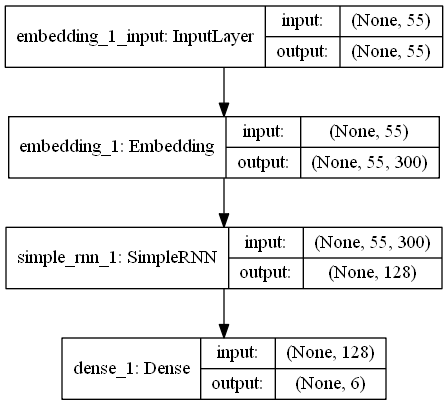

In [39]:
# plot_model(model, to_file='Figures/architecture-rnn.png', show_shapes=True, show_layer_names=True)

#### LSTM

In [40]:
model = create_LSTM_model()
model.summary()

Model: "Scam Classifier with LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 55, 300)           2728500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 2,948,922
Trainable params: 2,948,922
Non-trainable params: 0
_________________________________________________________________


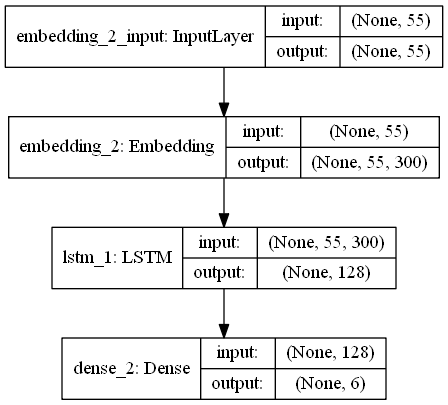

In [41]:
# plot_model(model, to_file='Figures/architecture-lstm.png', show_shapes=True, show_layer_names=True)

#### BiLSTM

In [42]:
model = create_BiLSTM_model()
model.summary()

Model: "Scam Classifier with BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 55, 300)           2728500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1542      
Total params: 3,169,338
Trainable params: 3,169,338
Non-trainable params: 0
_________________________________________________________________


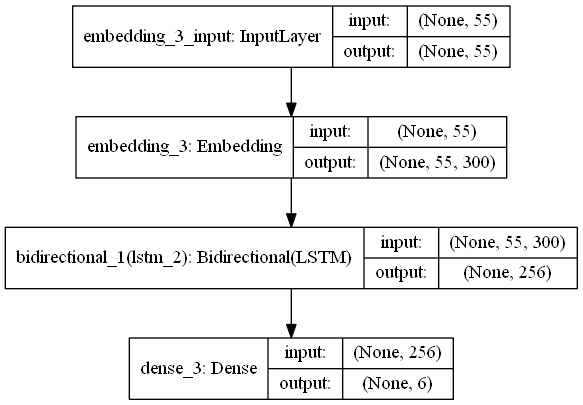

In [43]:
# plot_model(model, to_file='Figures/architecture-bilstm.png', show_shapes=True, show_layer_names=True)

### Training the models with 5-fold cross-validation

In [21]:
model_dict = {1: "RNN", 2: "LSTM", 3: "BiLSTM"}
acc_scores = []
training_time = []

for i, m in model_dict.items():
    model_name = model_dict.get(i)
    acc, time = k_fold_cv(X_train, Y_train, k=5, model_name=model_name, filedir="Models/Scam_Classifier/")
    acc_scores.append(acc)
    training_time.append(time)

j = len(acc_scores[0])   

# Initialise an empty dataframe
df = pd.DataFrame()
for i in range(j):
    fold = [scores[i] for scores in acc_scores]
    df2 = pd.DataFrame({"fold " + str(i):fold})
    df = pd.concat([df, df2], axis=1)
df3 = pd.DataFrame({"time": training_time})    
df = pd.concat([df, df3], axis=1)
df = df.set_index(pd.Series(["RNN", "LSTM", "BiLSTM"]))
print("End of Experiment")
df


==> vocab_size:  9092
==> maxlen:  55
==> embedding_dim:  200

Performing a 5-fold cross-validation for RNN model

Fold 1 ...



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2443 samples, validate on 611 samples
Epoch 1/30
2443/2443 [==============================] - 14s 6ms/step - loss: 1.5060 - accuracy: 0.4102 - val_loss: 1.3439 - val_accuracy: 0.4861

Epoch 00001: val_loss improved from inf to 1.34389, saving model to Models/Scam_Classifier/best-RNN-fold-1.h5
Epoch 2/30
2443/2443 [==============================] - 14s 6ms/step - loss: 1.0346 - accuracy: 0.6316 - val_loss: 1.1198 - val_accuracy: 0.6039

Epoch 00002: val_loss improved from 1.34389 to 1.11982, saving model to Models/Scam_Classifier/best-RNN-fold-1.h5
Epoch 3/30
2443/2443 [==============================] - 14s 6ms/step - loss: 0.6964 - accuracy: 0.7761 - val_loss: 1.1192 - val_accuracy: 0.5876

Epoch 00003: val_loss improved from 1.11982 to 1.11923, saving model to Models/Scam_Classifier/best-RNN-fold-1.h5
Epoch 4/30
2443/2443 [==============================] - 14s 6ms/step - loss: 0.4122 - accuracy: 0.8883 - val_loss: 1.2105 - val_accuracy: 0.6023

Epoch 00004: val_loss did not i

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2443 samples, validate on 611 samples
Epoch 1/30
2443/2443 [==============================] - 28s 11ms/step - loss: 1.1246 - accuracy: 0.5845 - val_loss: 0.9190 - val_accuracy: 0.6759

Epoch 00001: val_loss improved from inf to 0.91897, saving model to Models/Scam_Classifier/best-LSTM-fold-1.h5
Epoch 2/30
2443/2443 [==============================] - 27s 11ms/step - loss: 0.6269 - accuracy: 0.7949 - val_loss: 0.6199 - val_accuracy: 0.8052

Epoch 00002: val_loss improved from 0.91897 to 0.61992, saving model to Models/Scam_Classifier/best-LSTM-fold-1.h5
Epoch 3/30
2443/2443 [==============================] - 28s 12ms/step - loss: 0.3570 - accuracy: 0.9009 - val_loss: 0.5923 - val_accuracy: 0.8151

Epoch 00003: val_loss improved from 0.61992 to 0.59227, saving model to Models/Scam_Classifier/best-LSTM-fold-1.h5
Epoch 4/30
2443/2443 [==============================] - 28s 12ms/step - loss: 0.2207 - accuracy: 0.9398 - val_loss: 0.5980 - val_accuracy: 0.8462

Epoch 00004: val_loss di

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2443 samples, validate on 611 samples
Epoch 1/30
2443/2443 [==============================] - 54s 22ms/step - loss: 1.0638 - accuracy: 0.6136 - val_loss: 0.8875 - val_accuracy: 0.7136

Epoch 00001: val_loss improved from inf to 0.88750, saving model to Models/Scam_Classifier/best-BiLSTM-fold-1.h5
Epoch 2/30
2443/2443 [==============================] - 54s 22ms/step - loss: 0.5574 - accuracy: 0.8195 - val_loss: 0.7230 - val_accuracy: 0.7610

Epoch 00002: val_loss improved from 0.88750 to 0.72305, saving model to Models/Scam_Classifier/best-BiLSTM-fold-1.h5
Epoch 3/30
2443/2443 [==============================] - 53s 22ms/step - loss: 0.3929 - accuracy: 0.8825 - val_loss: 0.6407 - val_accuracy: 0.8069

Epoch 00003: val_loss improved from 0.72305 to 0.64072, saving model to Models/Scam_Classifier/best-BiLSTM-fold-1.h5
Epoch 4/30
2443/2443 [==============================] - 54s 22ms/step - loss: 0.2740 - accuracy: 0.9177 - val_loss: 0.5791 - val_accuracy: 0.8118

Epoch 00004: val_l

,fold 0,fold 1,fold 2,fold 3,fold 4,time
RNN,58.756137,61.374795,57.446808,57.774138,58.032787,883.221440
LSTM,85.433716,88.052374,87.725043,86.743045,80.819672,2294.614449
BiLSTM,81.178397,85.597384,86.579376,85.106385,83.442622,4025.409871


### Save results as a CSV file

In [22]:
df.to_csv("Results/scam_classification_no_pretrained.csv")

## With pre-trained GloVe word embeddings (300D)

### Preparing the GloVe word embeddings

In [45]:
glove_embedding_dict = get_glove_vectors(filename="Data/glove.6B.300d.txt")
embedding_matrix, h, m = filter_glove(tokenizer.word_index, glove_embedding_dict, embedding_dim=300)
print(embedding_matrix.shape)

Converted 7454 words (1640 misses)
(9095, 300)


### Preparing training data

In [48]:
X = data.lemmatised
y = data.scam_type_ids
X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
X_true = X_test
Y_true = Y_test

num_words = 8000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print("\n==> vocab_size: ", vocab_size)

# Set maximum length as the 80th percentile of the length of text in the dataset
maxlen = int(data.len_lemmatised.quantile(0.80))
print("==> maxlen: ", maxlen)

num_classes = len(data.scam_type.unique())
embedding_dim = 300
print("==> embedding_dim: ", embedding_dim)

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)


==> vocab_size:  9095
==> maxlen:  55
==> embedding_dim:  300


### Visualise the models

#### RNN

In [46]:
model = create_RNN_model_glove()
model.summary()

Model: "Scam Classifier with RNN and GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 55, 300)           2728500   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               54912     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 2,784,186
Trainable params: 55,686
Non-trainable params: 2,728,500
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='Figures/architecture-rnn-glove.png', show_shapes=True, show_layer_names=True)

#### LSTM

In [47]:
model = create_LSTM_model_glove()
model.summary()

Model: "Scam Classifier with LSTM and GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 55, 300)           2728500   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 2,948,922
Trainable params: 220,422
Non-trainable params: 2,728,500
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='Figures/architecture-lstm-glove.png', show_shapes=True, show_layer_names=True)

#### BiLSTM

In [27]:
model = create_BiLSTM_model_glove()
model.summary()

Model: "Scam Classifier with BiLSTM and GloVe"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 55, 300)           2727600   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 1542      
Total params: 3,168,438
Trainable params: 440,838
Non-trainable params: 2,727,600
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='Figures/architecture-bilstm-glove.png', show_shapes=True, show_layer_names=True)

### Training the models with 5-fold cross-validation

In [24]:
model_dict = {1: "RNN", 2: "LSTM", 3: "BiLSTM"}
acc_scores = []
training_time = []

for i, m in model_dict.items():
    model_name = model_dict.get(i)
    acc, time = k_fold_cv_glove(X_train, Y_train, k=5, model_name=model_name, filedir="Models/Scam_Classifier_Glove/")
    acc_scores.append(acc)
    training_time.append(time)

j = len(acc_scores[0])   

# Initialise an empty dataframe
df_glove = pd.DataFrame()
for i in range(j):
    fold = [scores[i] for scores in acc_scores]
    df2 = pd.DataFrame({"fold " + str(i):fold})
    df_glove = pd.concat([df_glove, df2], axis=1)
df3 = pd.DataFrame({"time": training_time})    
df_glove = pd.concat([df_glove, df3], axis=1)
df_glove = df_glove.set_index(pd.Series(["RNN", "LSTM", "BiLSTM"]))
print("End of Experiment")
df_glove


==> vocab_size:  9092
==> maxlen:  55
==> embedding_dim:  300

Performing a 5-fold cross-validation for RNN model

Fold 1 ...

Train on 2443 samples, validate on 611 samples
Epoch 1/30
2443/2443 [==============================] - 11s 5ms/step - loss: 1.3546 - accuracy: 0.4941 - val_loss: 1.2199 - val_accuracy: 0.5581

Epoch 00001: val_loss improved from inf to 1.21991, saving model to Models/Scam_Classifier_Glove/best-RNN-fold-1.h5
Epoch 2/30
2443/2443 [==============================] - 11s 4ms/step - loss: 1.0724 - accuracy: 0.6107 - val_loss: 1.2414 - val_accuracy: 0.5679

Epoch 00002: val_loss did not improve from 1.21991
Epoch 3/30
2443/2443 [==============================] - 11s 4ms/step - loss: 0.9605 - accuracy: 0.6594 - val_loss: 1.1785 - val_accuracy: 0.5974

Epoch 00003: val_loss improved from 1.21991 to 1.17852, saving model to Models/Scam_Classifier_Glove/best-RNN-fold-1.h5
Epoch 4/30
2443/2443 [==============================] - 11s 4ms/step - loss: 0.8811 - accuracy: 0.68

,fold 0,fold 1,fold 2,fold 3,fold 4,time
RNN,59.738135,61.538464,64.320785,58.101475,64.262295,745.610570
LSTM,87.397707,86.906713,86.415714,88.052374,86.557376,2308.584014
BiLSTM,86.252046,84.615386,86.088377,87.561375,85.901642,3794.771245


### Save results as a CSV file

In [25]:
df_glove.to_csv("Results/scam_classification_glove.csv")

## Evaluating on test set

### Load the results

In [56]:
df1 = pd.read_csv("Results/scam_classification_no_pretrained.csv")
df1.columns = ['model', '1', '2', '3', '4', '5', 'time']
df1['mode'] = 1 # for class imbalance
df1['combi'] = 1
df1['glove'] = 'N'

In [57]:
df1g = pd.read_csv("Results/scam_classification_glove.csv")
df1g.columns = ['model', '1', '2', '3', '4', '5', 'time']
df1g['mode'] = 1 # for class imbalance
df1g['combi'] = 2
df1g['glove'] = 'Y'

In [58]:
results_df = pd.concat([df1, df1g], axis=0)
results_df['mean_acc'] = round(results_df.drop(columns=['model', 'time', 'mode', 'combi', 'glove']).mean(axis=1), 1)
results_df['time'] = round(results_df['time'])
results_df['fold_max'] = results_df[['1', '2', '3', '4', '5']].idxmax(axis=1)
results_df = results_df[['model',  'combi', 'mode', 'glove', 'fold_max','mean_acc', 'time']]
results_df

,model,combi,mode,glove,fold_max,mean_acc,time
0,RNN,1,1,N,3,58.9,640.0
1,LSTM,1,1,N,1,85.2,1358.0
2,BiLSTM,1,1,N,2,84.3,2520.0
0,RNN,2,1,Y,2,62.3,525.0
1,LSTM,2,1,Y,4,86.9,1582.0
2,BiLSTM,2,1,Y,4,86.9,2921.0


In [65]:
folder_list = ['Scam_Classifier', 'Scam_Classifier_Glove']

<START OF EVALUATION>

[Scam Classifier]

Loading best RNN model from --> Models/Scam_Classifier/best-RNN-fold-2.h5
Average Validation Accuracy: 58.7%
Accuracy on Test Set:	61.1%
Classification Report:



C:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.00      0.00      0.00        39
Home/Room Rental Scam       0.00      0.00      0.00        45
   Impersonation Scam       0.85      0.93      0.89       322
   Internet Love Scam       0.48      0.29      0.36       142
      Investment Scam       0.33      0.08      0.12        53
 Online Purchase Scam       0.39      0.74      0.51       163

             accuracy                           0.61       764
            macro avg       0.34      0.34      0.31       764
         weighted avg       0.55      0.61      0.56       764

Classification report saved at --> Results/Classification_Reports/

Confusion Matrix:



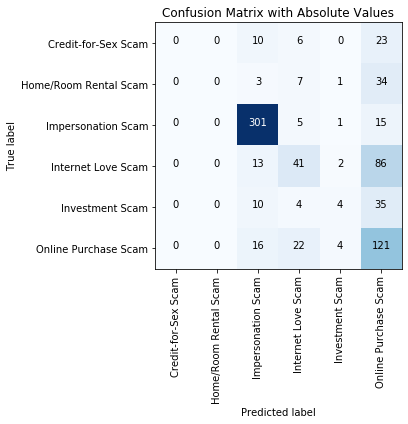

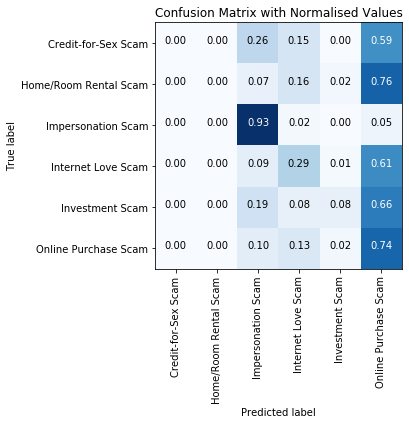

Confusion matrix saved at --> Results/Confusion_Matrix/

[Scam Classifier]

Loading best LSTM model from --> Models/Scam_Classifier/best-LSTM-fold-2.h5
Average Validation Accuracy: 85.8%
Accuracy on Test Set:	84.0%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.79      0.67      0.72        39
Home/Room Rental Scam       0.84      0.80      0.82        45
   Impersonation Scam       0.93      0.91      0.92       322
   Internet Love Scam       0.84      0.79      0.81       142
      Investment Scam       0.65      0.68      0.67        53
 Online Purchase Scam       0.75      0.85      0.80       163

             accuracy                           0.84       764
            macro avg       0.80      0.78      0.79       764
         weighted avg       0.84      0.84      0.84       764

Classification report saved at --> Results/Classification_Reports/

Confusion Matrix:



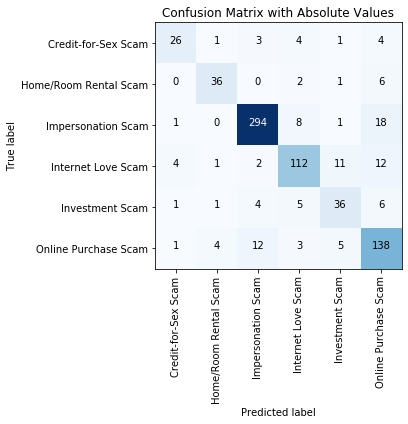

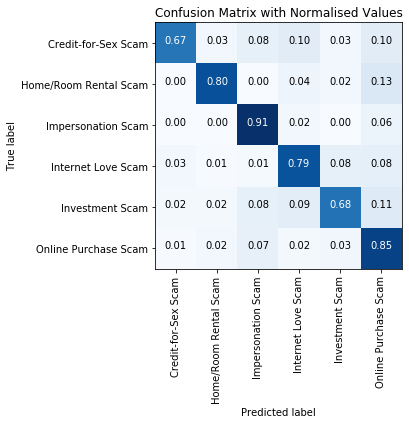

Confusion matrix saved at --> Results/Confusion_Matrix/

[Scam Classifier]

Loading best BiLSTM model from --> Models/Scam_Classifier/best-BiLSTM-fold-3.h5
Average Validation Accuracy: 84.4%
Accuracy on Test Set:	85.7%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.76      0.67      0.71        39
Home/Room Rental Scam       0.84      0.91      0.87        45
   Impersonation Scam       0.96      0.89      0.92       322
   Internet Love Scam       0.86      0.89      0.88       142
      Investment Scam       0.60      0.60      0.60        53
 Online Purchase Scam       0.78      0.87      0.83       163

             accuracy                           0.86       764
            macro avg       0.80      0.81      0.80       764
         weighted avg       0.86      0.86      0.86       764

Classification report saved at --> Results/Classification_Reports/

Confusion Matrix:



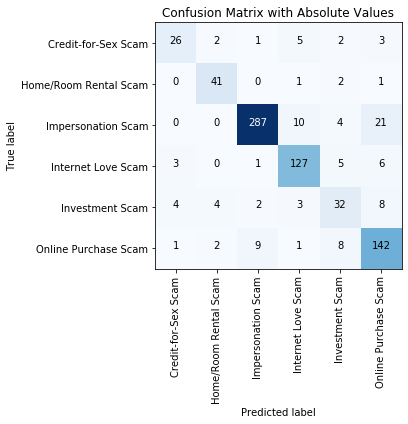

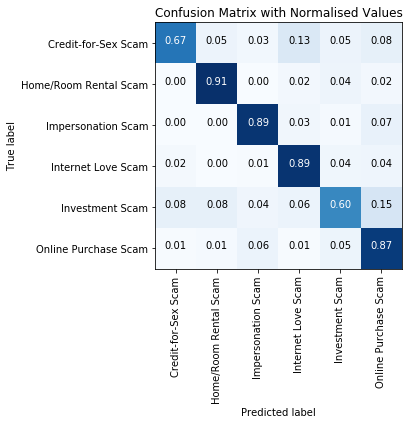

Confusion matrix saved at --> Results/Confusion_Matrix/

[Scam Classifier]

Loading best RNN model from --> Models/Scam_Classifier_Glove/best-RNN-fold-3.h5
Average Validation Accuracy: 61.6%
Accuracy on Test Set:	60.5%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.17      0.05      0.08        39
Home/Room Rental Scam       0.25      0.09      0.13        45
   Impersonation Scam       0.87      0.88      0.87       322
   Internet Love Scam       0.39      0.49      0.43       142
      Investment Scam       0.35      0.15      0.21        53
 Online Purchase Scam       0.46      0.60      0.52       163

             accuracy                           0.60       764
            macro avg       0.41      0.37      0.37       764
         weighted avg       0.58      0.60      0.58       764

Classification report saved at --> Results/Classification_Reports/

Confusion Matrix:



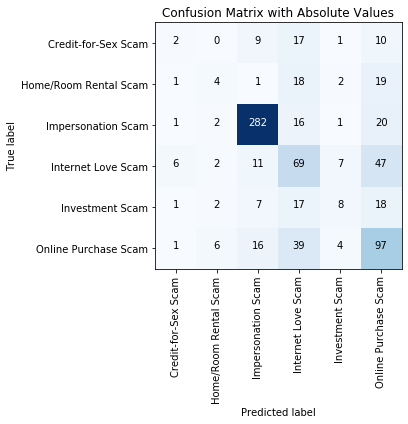

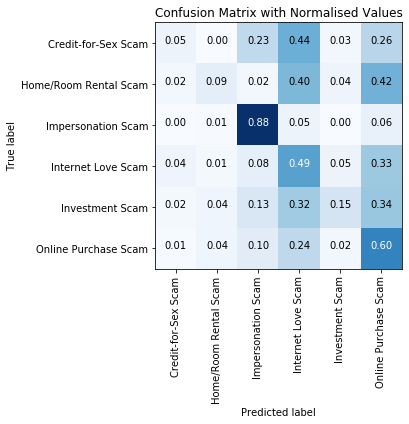

Confusion matrix saved at --> Results/Confusion_Matrix/

[Scam Classifier]

Loading best LSTM model from --> Models/Scam_Classifier_Glove/best-LSTM-fold-4.h5
Average Validation Accuracy: 87.1%
Accuracy on Test Set:	85.2%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.76      0.79      0.77        39
Home/Room Rental Scam       0.87      0.87      0.87        45
   Impersonation Scam       0.91      0.94      0.92       322
   Internet Love Scam       0.86      0.75      0.80       142
      Investment Scam       0.69      0.66      0.67        53
 Online Purchase Scam       0.80      0.84      0.82       163

             accuracy                           0.85       764
            macro avg       0.81      0.81      0.81       764
         weighted avg       0.85      0.85      0.85       764

Classification report saved at --> Results/Classification_Reports/

Confusion Matrix:



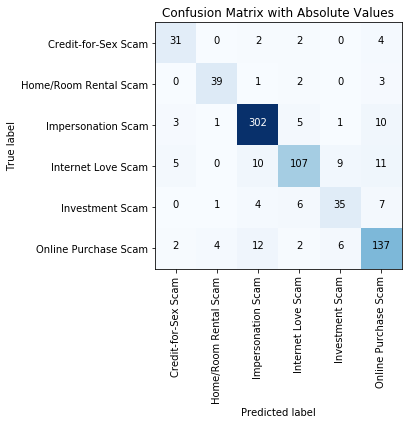

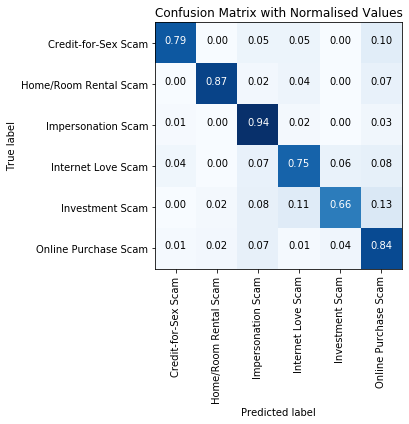

Confusion matrix saved at --> Results/Confusion_Matrix/

[Scam Classifier]

Loading best BiLSTM model from --> Models/Scam_Classifier_Glove/best-BiLSTM-fold-4.h5
Average Validation Accuracy: 86.1%
Accuracy on Test Set:	85.5%
Classification Report:

                       precision    recall  f1-score   support

  Credit-for-Sex Scam       0.74      0.72      0.73        39
Home/Room Rental Scam       0.97      0.76      0.85        45
   Impersonation Scam       0.91      0.93      0.92       322
   Internet Love Scam       0.85      0.84      0.84       142
      Investment Scam       0.91      0.55      0.68        53
 Online Purchase Scam       0.76      0.88      0.82       163

             accuracy                           0.85       764
            macro avg       0.86      0.78      0.81       764
         weighted avg       0.86      0.85      0.85       764

Classification report saved at --> Results/Classification_Reports/

Confusion Matrix:



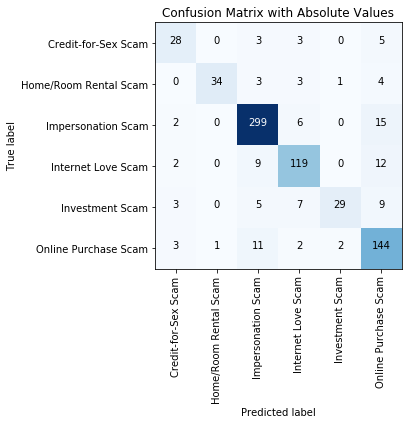

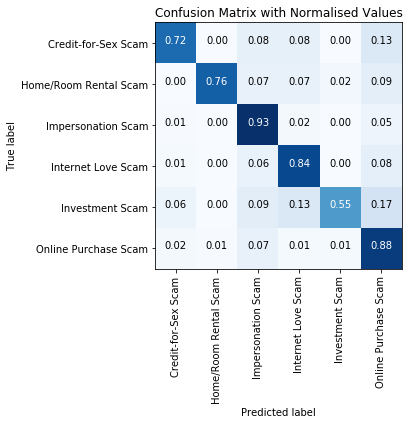

Confusion matrix saved at --> Results/Confusion_Matrix/
<END OF EVALUATION>


In [66]:
cat_mapping = dict(enumerate(data['scam_type'].cat.categories))
label_names = list(cat_mapping.values())
test_acc = []
print("<START OF EVALUATION>")

for i, j in results_df.iterrows():

    print("\n[Scam Classifier]\n")
  
    # Define filepath and filename to access models which gave highest validation accuracy
    filepath = "Models/" + folder_list[j['combi']-3]
    filename = "/best-" + j['model'] + "-fold-" + j['fold_max'] + ".h5"
    full_filepath = filepath + filename
    print("Loading best", j['model'], "model from -->", full_filepath)
    print("Average Validation Accuracy: %.1f%%" % j['mean_acc'])

    # Load model
    best_model = load_model(full_filepath)

    # Evaluate on the test dataset and print results
    _, acc = best_model.evaluate(X_test, to_categorical(Y_test), batch_size=16, verbose=2)
    test_acc.append(acc*100)
    print("Accuracy on Test Set:\t{0}%".format(round(acc*100,1)))
    
    # Classification report    
    pred_probabilities = best_model.predict(X_test)
    Y_pred = [np.argmax(x) for x in pred_probabilities]
    print("Classification Report:\n")
    print(classification_report(list(Y_true), Y_pred, target_names=label_names))
    
    # Save classification report as CSV file
    report = classification_report(list(Y_true), Y_pred, target_names=label_names, output_dict=True)
    filepath_cr = "Results/Classification_Reports/" 
    filename_cr = folder_list[j['combi']-1] + "-best-" + j['model'] + ".csv"
    cr_df = pd.DataFrame(report).transpose()
    cr_df.to_csv(filepath_cr + filename_cr)
    print("Classification report saved at -->", filepath_cr)

    # Print and save confusion matrix
    print("\nConfusion Matrix:\n")
    cm = confusion_matrix(list(Y_true), Y_pred)
    filepath_cm = "Results/Confusion_Matrix/"
    filename_cm = folder_list[j['combi']-3] + "-best-" + j['model'] + ".png"
    plot_confusion_matrix(cm, classes=label_names, path=filepath_cm + filename_cm)
    
    filepath_cm_norm = "Results/Confusion_Matrix_Normalised/"
    filename_cm_norm = folder_list[j['combi']-1] + "-best-normalised-" + j['model'] + ".png"
    plot_confusion_matrix(cm, normalize=True, classes=label_names, path=filepath_cm_norm + filename_cm_norm)
    print("Confusion matrix saved at -->", filepath_cm)
    print("Normalised confusion matrix saved at -->", filepath_cm_norm)

print("\n<END OF EVALUATION>")

In [67]:
# Reset index
results_df = results_df.reset_index().drop(columns='index')

# Initialise new column to store test accuracy
results_df = results_df.assign(test_acc="")

# Loop through the dataset to extract scammer name and contract from the scammer_details column
for idx, row in results_df.iterrows():
    results_df.loc[idx, 'test_acc'] = round(test_acc[idx], 1)

results_df

,model,combi,mode,glove,fold_max,mean_acc,time,test_acc
0,RNN,1,1,N,2,58.7,883.0,61.1
1,LSTM,1,1,N,2,85.8,2295.0,84
2,BiLSTM,1,1,N,3,84.4,4025.0,85.7
3,RNN,2,1,Y,3,61.6,746.0,60.5
4,LSTM,2,1,Y,4,87.1,2309.0,85.2
5,BiLSTM,2,1,Y,4,86.1,3795.0,85.5


## Save all results as a CSV file

In [68]:
results_df.to_csv("Results/scam_classification_results.csv")